In [ ]:
import zipfile
from PIL import Image
import io

# Open the zip file
with zipfile.ZipFile('archive (3).zip', 'r') as zip_ref:
    # List all files in the zip file
    file_list = zip_ref.namelist()

    # Iterate over each file in the zip file
    for file_name in file_list:
        # Check if the file is an image file
        if file_name.endswith('.jpg') or file_name.endswith('.png'):
            # Extract the image file
            with zip_ref.open(file_name) as image_file:
                # Read the image file using PIL
                image_data = io.BytesIO(image_file.read())
                image = Image.open(image_data)

                # Print the image file name and display the image
                print("Image:", file_name)
                image.show


Image: test/daisy/10466290366_cc72e33532_jpg.rf.6ddc91cd5d4a6a683e567ccb37e5a089.jpg
Image: test/daisy/10466558316_a7198b87e2_jpg.rf.7acf642b94dc98daa49482a12994ac4c.jpg
Image: test/daisy/12193032636_b50ae7db35_n_jpg.rf.e6c4eeb71c56e793a0d85f6d979dbe20.jpg
Image: test/daisy/1342002397_9503c97b49_jpg.rf.8fe6bdd23186b70f089bb0c5b89d314e.jpg
Image: test/daisy/1354396826_2868631432_m_jpg.rf.409eee37613d16dbc71365cb5615327e.jpg
Image: test/daisy/1374193928_a52320eafa_jpg.rf.e398f632151f3ccc5729bc89527d7614.jpg
Image: test/daisy/1392131677_116ec04751_jpg.rf.da99f9bb579ee96dc1728545ca519d6f.jpg
Image: test/daisy/14333681205_a07c9f1752_m_jpg.rf.6ff96d9fe33f0bd19a18425f32d470b1.jpg
Image: test/daisy/14399435971_ea5868c792_jpg.rf.89b733453e10d461d440acc99b7ef6d1.jpg
Image: test/daisy/14564545365_1f1d267bf1_n_jpg.rf.b848a44633a90175f6df714901554324.jpg
Image: test/daisy/14569895116_32f0dcb0f9_jpg.rf.73199cb0ad1cb9aa37d36b16a3c9b46c.jpg
Image: test/daisy/14591326135_930703dbed_m_jpg.rf.10cc8279dba

## VGG16

Found 1021 images belonging to 2 classes.
Found 254 images belonging to 2 classes.
Found 182 images belonging to 2 classes.
58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/100
31/31 [==============================] - 768s 25s/step - loss: 2.1629 - accuracy: 0.6684 - val_loss: 0.4020 - val_accuracy: 0.8125
Epoch 2/100
31/31 [==============================] - 753s 24s/step - loss: 0.5380 - accuracy: 0.7897 - val_loss: 0.2948 - val_accuracy: 0.8527
Epoch 3/100
31/31 [==============================] - 737s 24s/step - loss: 0.3468 - accuracy: 0.8696 - val_loss: 0.2785 - val_accuracy: 0.8571
Epoch 4/100
31/31 [==============================] - 738s 24s/step - loss: 0.2745 - accuracy: 0.8807 - val_loss: 0.2491 - val_accuracy: 0.8661
Epoch 5/100
31/31 [==============================] - 748s 24s/step - loss: 0.1638 - accuracy: 0.9323 - val_loss: 0.2240 - val_accuracy: 0.9062
Epoch 6/100
31/31 [==============================] - 748s 24s/step - loss: 0.1341 - accuracy: 0.

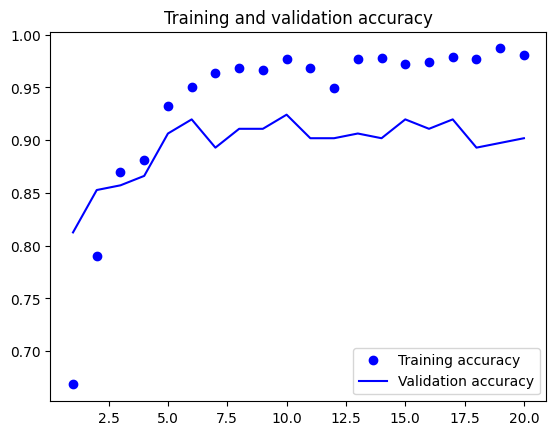

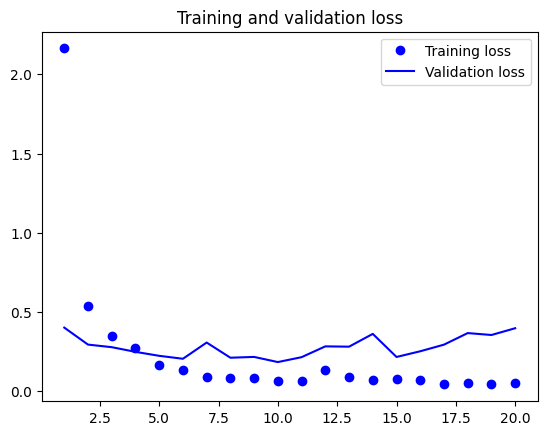

In [ ]:
import numpy as np
import zipfile
import os
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Extract the provided zip file
with zipfile.ZipFile('archive (3).zip', 'r') as zip_ref:
    zip_ref.extractall('archive (3)')

# Define directories for train, validation, and test sets
train_dir = 'archive (3)/train'
val_dir = 'archive (3)/validation'
test_dir = 'archive (3)/test'

# Create validation directory if it doesn't exist
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

# Define the ratio of data to move to the validation set
validation_split = 0.2

# Move a portion of the training data to the validation directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    files = os.listdir(class_dir)
    num_validation = int(len(files) * validation_split)
    validation_files = files[:num_validation]
    for file in validation_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(val_dir, class_name, file)
        if not os.path.exists(dst):
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.move(src, dst)
        else:
            print(f"Warning: Destination path '{dst}' already exists. Skipping.")

# Image dimensions
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers with dropout
model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),  # Adding dropout layer
    Dense(512, activation='relu'),
    Dropout(0.3),  # Adding dropout layer
    Dense(2, activation='softmax')  #  3 classes for classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping callback
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=100,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    callbacks=[early_stopping])  # Pass early stopping callback here

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## LeNet

Found 1021 images belonging to 2 classes.
Found 254 images belonging to 2 classes.
Epoch 1/100
31/31 [==============================] - 6s 146ms/step - loss: 0.6988 - accuracy: 0.5602 - val_loss: 0.6823 - val_accuracy: 0.5893
Epoch 2/100
31/31 [==============================] - 3s 97ms/step - loss: 0.6699 - accuracy: 0.6047 - val_loss: 0.6659 - val_accuracy: 0.6161
Epoch 3/100
31/31 [==============================] - 3s 91ms/step - loss: 0.6441 - accuracy: 0.6077 - val_loss: 0.6210 - val_accuracy: 0.6652
Epoch 4/100
31/31 [==============================] - 4s 128ms/step - loss: 0.6235 - accuracy: 0.6421 - val_loss: 0.6183 - val_accuracy: 0.6295
Epoch 5/100
31/31 [==============================] - 3s 94ms/step - loss: 0.6037 - accuracy: 0.6815 - val_loss: 0.5643 - val_accuracy: 0.7321
Epoch 6/100
31/31 [==============================] - 3s 97ms/step - loss: 0.5546 - accuracy: 0.7270 - val_loss: 0.5780 - val_accuracy: 0.7054
Epoch 7/100
31/31 [==============================] - 4s 121ms/s

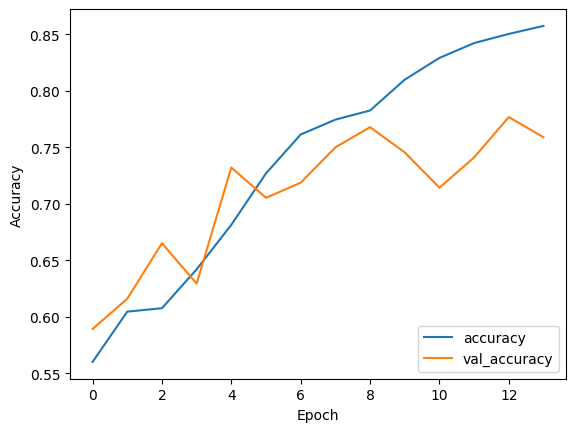

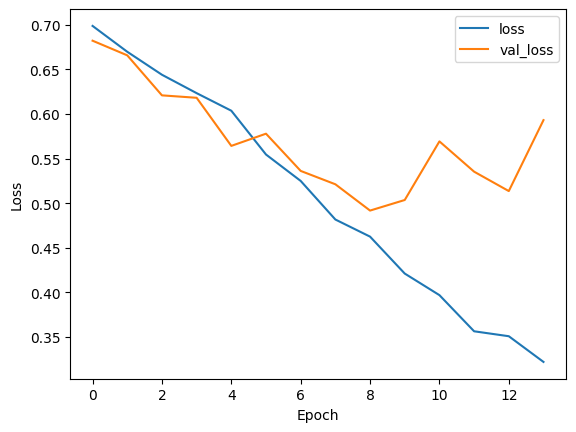

Found 182 images belonging to 2 classes.
6/6 [==============================] - 0s 63ms/step - loss: 0.4821 - accuracy: 0.8132
Test accuracy: 0.8131868243217468


In [ ]:
import numpy as np
import zipfile
import os
import shutil
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Extract the provided zip file
with zipfile.ZipFile('archive (3).zip', 'r') as zip_ref:
    zip_ref.extractall('archive (3)')

# Define directories for train, validation, and test sets
train_dir = 'archive (3)/train'
val_dir = 'archive (3)/validation'
test_dir = 'archive (3)/test'

# Create validation directory if it doesn't exist
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

# Define the ratio of data to move to the validation set
validation_split = 0.2  # You can adjust this ratio as needed

# Move a portion of the training data to the validation directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    files = os.listdir(class_dir)
    num_validation = int(len(files) * validation_split)
    validation_files = files[:num_validation]
    for file in validation_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(val_dir, class_name)
        os.makedirs(dst, exist_ok=True)

        # Handle destination file already exists
        dst_file = os.path.join(dst, file)
        if os.path.exists(dst_file):
            # Rename the file before moving it
            base_name, ext = os.path.splitext(file)
            new_name = base_name + '_1' + ext
            dst_file = os.path.join(dst, new_name)

        shutil.move(src, dst_file)

# Image dimensions
img_height, img_width = 32, 32  # LeNet uses smaller input size
batch_size = 32

# Preprocess data
train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# LeNet Model
model = Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dropout(0.5),  # Dropout layer with dropout rate of 0.5
    Dense(84, activation='relu'),
    Dropout(0.5),  # Dropout layer with dropout rate of 0.5
    Dense(2, activation='softmax')  #  3 classes for classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=100,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    callbacks=[early_stopping])  # Pass the early stopping callback

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)


## AelxNet

Found 1021 images belonging to 2 classes.
Found 254 images belonging to 2 classes.
Epoch 1/100
31/31 [==============================] - 101s 3s/step - loss: 0.7116 - accuracy: 0.5632 - val_loss: 0.6749 - val_accuracy: 0.5982
Epoch 2/100
31/31 [==============================] - 103s 3s/step - loss: 0.6782 - accuracy: 0.5854 - val_loss: 0.6763 - val_accuracy: 0.5938
Epoch 3/100
31/31 [==============================] - 98s 3s/step - loss: 0.7661 - accuracy: 0.5865 - val_loss: 0.6817 - val_accuracy: 0.5759
Epoch 4/100
31/31 [==============================] - 103s 3s/step - loss: 0.6802 - accuracy: 0.5854 - val_loss: 0.6769 - val_accuracy: 0.5938
Epoch 5/100
31/31 [==============================] - 103s 3s/step - loss: 0.6800 - accuracy: 0.5875 - val_loss: 0.6765 - val_accuracy: 0.5938
Epoch 6/100
31/31 [==============================] - 103s 3s/step - loss: 0.6817 - accuracy: 0.5824 - val_loss: 0.6787 - val_accuracy: 0.5848


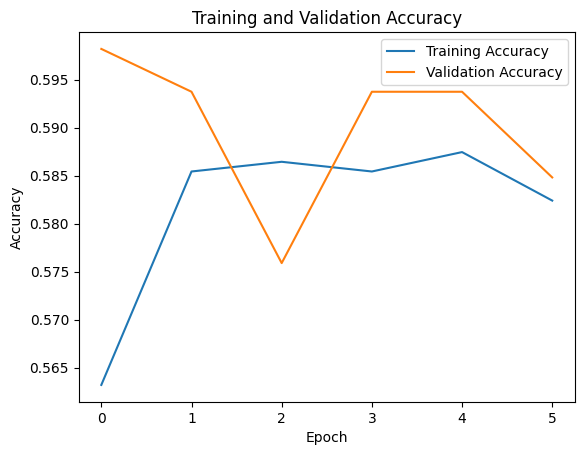

Found 182 images belonging to 2 classes.
6/6 [==============================] - 4s 668ms/step - loss: 0.6854 - accuracy: 0.5769
Test accuracy: 0.5769230723381042


In [ ]:
import numpy as np
import zipfile
import os
import shutil
import time
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Extract the provided zip file
with zipfile.ZipFile('archive (3).zip', 'r') as zip_ref:
    zip_ref.extractall('archive (3)')

# Define directories for train, validation, and test sets
train_dir = 'archive (3)/train'
val_dir = 'archive (3)/validation'
test_dir = 'archive (3)/test'

# Create validation directory if it doesn't exist
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

# Define the ratio of data to move to the validation set
validation_split = 0.2  # You can adjust this ratio as needed

# Move a portion of the training data to the validation directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    files = os.listdir(class_dir)
    num_validation = int(len(files) * validation_split)
    validation_files = files[:num_validation]
    for file in validation_files:
        src = os.path.join(class_dir, file)
        timestamp = str(time.time()).replace('.', '')  # Append a timestamp to the file name
        dst = os.path.join(val_dir, class_name, timestamp + '_' + file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)

# Image dimensions
img_height, img_width = 227, 227  # AlexNet uses larger input size
batch_size = 32

# Preprocess data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# AlexNet Model
model = Sequential([
    Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Conv2D(256, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Conv2D(384, kernel_size=(3, 3), activation='relu'),
    Conv2D(384, kernel_size=(3, 3), activation='relu'),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  #  3 classes for classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=100,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    callbacks=[early_stopping])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)


##EfficientNet

In [ ]:
pip install efficientnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00


Found 1021 images belonging to 2 classes.
Found 508 images belonging to 2 classes.
16804768/16804768 [==============================] - 0s 0us/step
Epoch 1/100
31/31 [==============================] - 131s 4s/step - loss: 0.2979 - accuracy: 0.8574 - val_loss: 0.1530 - val_accuracy: 0.9438
Epoch 2/100
31/31 [==============================] - 113s 4s/step - loss: 0.1891 - accuracy: 0.9211 - val_loss: 0.1063 - val_accuracy: 0.9542
Epoch 3/100
31/31 [==============================] - 103s 3s/step - loss: 0.1595 - accuracy: 0.9312 - val_loss: 0.0968 - val_accuracy: 0.9521
Epoch 4/100
31/31 [==============================] - 111s 4s/step - loss: 0.1264 - accuracy: 0.9424 - val_loss: 0.1000 - val_accuracy: 0.9583
Epoch 5/100
31/31 [==============================] - 105s 3s/step - loss: 0.1373 - accuracy: 0.9434 - val_loss: 0.0976 - val_accuracy: 0.9500
Epoch 6/100
31/31 [==============================] - 112s 4s/step - loss: 0.1304 - accuracy: 0.9444 - val_loss: 0.0901 - val_accuracy: 0.9458


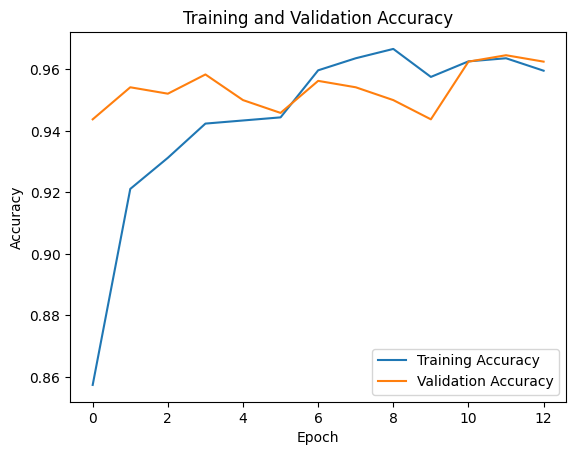

Found 182 images belonging to 2 classes.
6/6 [==============================] - 13s 2s/step - loss: 0.1647 - accuracy: 0.9286
Test accuracy: 0.9285714030265808


In [ ]:
import numpy as np
import zipfile
import os
import shutil
import time
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping

# Extract the provided zip file
with zipfile.ZipFile('archive (3).zip', 'r') as zip_ref:
    zip_ref.extractall('archive (3)')

# Define directories for train, validation, and test sets
train_dir = 'archive (3)/train'
val_dir = 'archive (3)/validation'
test_dir = 'archive (3)/test'

# Create validation directory if it doesn't exist
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

# Define the ratio of data to move to the validation set
validation_split = 0.2  # You can adjust this ratio as needed

# Move a portion of the training data to the validation directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    files = os.listdir(class_dir)
    num_validation = int(len(files) * validation_split)
    validation_files = files[:num_validation]
    for file in validation_files:
        src = os.path.join(class_dir, file)
        timestamp = str(time.time()).replace('.', '')  # Append a timestamp to the file name
        dst = os.path.join(val_dir, class_name, timestamp + '_' + file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)

# Image dimensions
img_height, img_width = 224, 224  # EfficientNetB0 input size
batch_size = 32

# Preprocess data (without data augmentation)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Set class_mode to 'binary' for binary classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Set class_mode to 'binary' for binary classification
)

# EfficientNetB0 Model with Global Average Pooling
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the pre-trained weights

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Add Global Average Pooling layer
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=100,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    callbacks=[early_stopping])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Set class_mode to 'binary' for binary classification
)

test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)


## Inception net

Found 1021 images belonging to 2 classes.
Found 254 images belonging to 2 classes.
87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/100
31/31 [==============================] - 278s 9s/step - loss: 0.3411 - accuracy: 0.8726 - val_loss: 0.2455 - val_accuracy: 0.8973
Epoch 2/100
31/31 [==============================] - 299s 10s/step - loss: 0.1667 - accuracy: 0.9353 - val_loss: 0.2164 - val_accuracy: 0.9107
Epoch 3/100
31/31 [==============================] - 311s 10s/step - loss: 0.1838 - accuracy: 0.9272 - val_loss: 0.1953 - val_accuracy: 0.9241
Epoch 4/100
31/31 [==============================] - 310s 10s/step - loss: 0.1298 - accuracy: 0.9515 - val_loss: 0.1198 - val_accuracy: 0.9509
Epoch 5/100
31/31 [==============================] - 279s 9s/step - loss: 0.1164 - accuracy: 0.9565 - val_loss: 0.1487 - val_accuracy: 0.9509
Epoch 6/100
31/31 [==============================] - 307s 10s/step - loss: 0.1228 - accuracy: 0.9535 - val_loss: 0.1616 - val_accuracy: 0.9

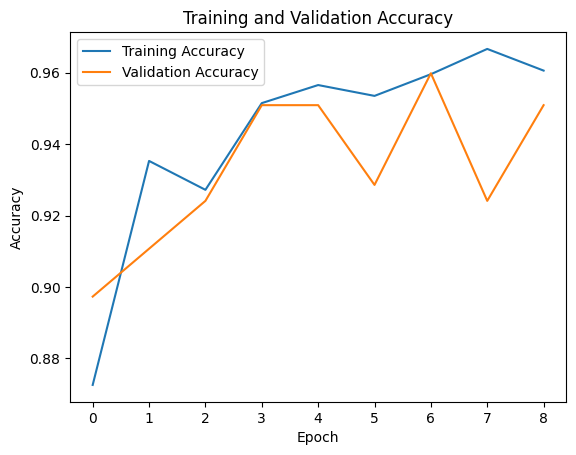

Found 182 images belonging to 2 classes.
6/6 [==============================] - 41s 7s/step - loss: 0.1717 - accuracy: 0.9341
Test Accuracy: 0.9340659379959106


In [ ]:
import numpy as np
import zipfile
import os
import shutil
import time
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping

# Extract the provided zip file
with zipfile.ZipFile('archive (3).zip', 'r') as zip_ref:
    zip_ref.extractall('archive (3)')

# Define directories for train, validation, and test sets
train_dir = 'archive (3)/train'
val_dir = 'archive (3)/validation'
test_dir = 'archive (3)/test'

# Create validation directory if it doesn't exist
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

# Define the ratio of data to move to the validation set
validation_split = 0.2

# Move a portion of the training data to the validation directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    files = os.listdir(class_dir)
    num_validation = int(len(files) * validation_split)
    validation_files = files[:num_validation]
    for file in validation_files:
        src = os.path.join(class_dir, file)
        timestamp = str(time.time()).replace('.', '')  # Append a timestamp to the file name
        dst = os.path.join(val_dir, class_name, timestamp + '_' + file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)

# Image dimensions
img_height, img_width = 299, 299
batch_size = 32

# Preprocess data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Ensure class_mode is set to 'binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Ensure class_mode is set to 'binary'
)

# InceptionV3 Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the pre-trained weights

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),  # Add dropout layer
    Dense(512, activation='relu'),
    Dropout(0.5),  # Add dropout layer
    Dense(1, activation='sigmoid')  # Add activation='sigmoid' for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=100,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    callbacks=[early_stopping])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Ensure class_mode is set to 'binary'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)


## ResNet

In [ ]:
import numpy as np
import zipfile
import os
import shutil
import time
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

# Extract the provided zip file
with zipfile.ZipFile('archive (3).zip', 'r') as zip_ref:
    zip_ref.extractall('archive (3)')

# Define directories for train, validation, and test sets
train_dir = 'archive (3)/train'
val_dir = 'archive (3)/validation'
test_dir = 'archive (3)/test'

# Create validation directory if it doesn't exist
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

# Define the ratio of data to move to the validation set
validation_split = 0.2

# Move a portion of the training data to the validation directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    files = os.listdir(class_dir)
    num_validation = int(len(files) * validation_split)
    validation_files = files[:num_validation]
    for file in validation_files:
        src = os.path.join(class_dir, file)
        timestamp = str(time.time()).replace('.', '')
        dst = os.path.join(val_dir, class_name, timestamp + '_' + file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)

# Image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Preprocess data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the pre-trained weights

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with Early Stopping
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=100,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    callbacks=[early_stopping])  # Add EarlyStopping callback

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)


Found 1021 images belonging to 2 classes.
Found 762 images belonging to 2 classes.
Epoch 1/100
31/31 [==============================] - 412s 13s/step - loss: 0.6340 - accuracy: 0.6764 - val_loss: 0.5194 - val_accuracy: 0.7337
Epoch 2/100
31/31 [==============================] - 392s 13s/step - loss: 0.5864 - accuracy: 0.6996 - val_loss: 0.5830 - val_accuracy: 0.7052
Epoch 3/100
31/31 [==============================] - 331s 11s/step - loss: 0.5349 - accuracy: 0.7361 - val_loss: 0.5048 - val_accuracy: 0.7391
Epoch 4/100
31/31 [==============================] - ETA: 0s - loss: 0.5497 - accuracy: 0.7482